In [1]:
%load_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import iqr
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.time import Time
from astropy.timeseries import LombScargle
from astropy.wcs import WCS
from astropy import units as u
from astropy.io import fits
from astropy import constants
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support
from tqdm import tqdm


In [2]:
#Move up to RAFTS directory
if os.getcwd().endswith('/RAFTS'):
    pass
else:
    os.chdir('..')

In [3]:
pwd

'/Users/fbianco/RAFTS'

In [4]:
!pip install photutils

In [6]:

from utils import filt_interp, dpar, dtan, lamb_eff_md, dcr_offset, celest_to_pa, inverse_Teff, inverseTeff, inverseWeff, lorentzian, find_min_max_adjacent, variance_weighted_mean, chrDistAng
import globals
import defs as defs


from config import *


In [7]:
hdu_list = fits.open('dwfflare/0a7936112f3150350b27277900f88de2_c4d_151218_061807_ooi_g_v1.fits.fz')
hdu_list.info()

Filename: dwfflare/0a7936112f3150350b27277900f88de2_c4d_151218_061807_ooi_g_v1.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     251   ()      
  1  S29           1 CompImageHDU    129   (2046, 4094)   float32   
  2  S31           1 CompImageHDU    129   (2046, 4094)   float32   
  3  S25           1 CompImageHDU    129   (2046, 4094)   float32   
  4  S26           1 CompImageHDU    129   (2046, 4094)   float32   
  5  S27           1 CompImageHDU    129   (2046, 4094)   float32   
  6  S28           1 CompImageHDU    129   (2046, 4094)   float32   
  7  S20           1 CompImageHDU    129   (2046, 4094)   float32   
  8  S21           1 CompImageHDU    129   (2046, 4094)   float32   
  9  S22           1 CompImageHDU    129   (2046, 4094)   float32   
 10  S23           1 CompImageHDU    129   (2046, 4094)   float32   
 11  S24           1 CompImageHDU    129   (2046, 4094)   float32   
 12  S14           1 CompImageHDU    129 

In [8]:
hdu_list[16].data

array([[28.64088 , 31.617392, 24.957178, ..., 27.005594, 32.783024,
        29.117338],
       [20.971172, 30.57876 , 24.09615 , ..., 23.898054, 27.95859 ,
        20.740602],
       [28.406326, 25.357933, 29.101353, ..., 29.05602 , 25.20106 ,
        18.529772],
       ...,
       [26.60759 , 34.178654, 29.469402, ..., 30.430195, 37.16763 ,
        21.072706],
       [22.315039, 34.979946, 32.176346, ..., 27.95241 , 32.472675,
        18.84519 ],
       [37.708824, 38.4955  , 28.122744, ..., 32.688633, 38.295967,
        35.173634]], dtype=float32)

In [9]:
imnames = np.array(os.listdir('dwfflare'))
imnames = np.array([i for i in imnames if i.endswith("fits.fz") or i.endswith("fits")])
len(imnames)

74

In [10]:
print(f"image sequence length {len(imnames)}")

image sequence length 74


In [11]:
#Collect DATE-OBS list
datelist = []

for i, imname in enumerate(imnames):
    try:
        image_header = fits.getheader('dwfflare/' + imname, ext=0)
        datelist.append(image_header['DATE-OBS'])

    except:
        print(i, 'EXT not found')
        datelist.append(image_header['DATE-OBS'])

datearr = np.array(datelist)
len(datearr)

74

In [12]:
#Find .fits files that are missing S18 extension
badinds = []
for i, imname in enumerate(imnames):
    try:
        image_data = fits.getheader('dwfflare/' + imname, ext=16)

    except:
        print(i, 'EXT not found')
        badinds.append(i)

badinds = np.array(badinds)
print(f"bad images {badinds}")

bad images []


In [13]:
mask = np.ones(len(imnames), dtype=int)
if len(badinds) > 0:
    mask[badinds] = 0

mask = mask > 0
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [14]:
imnames_timeordered = imnames[mask][np.argsort(datearr[mask])]
np.save('Outdata/imnames_timeordered.npy', imnames_timeordered)

b5179de7a72a8849306cf70093d016bc_c4d_151218_054742_ooi_g_v1.fits.fz 0


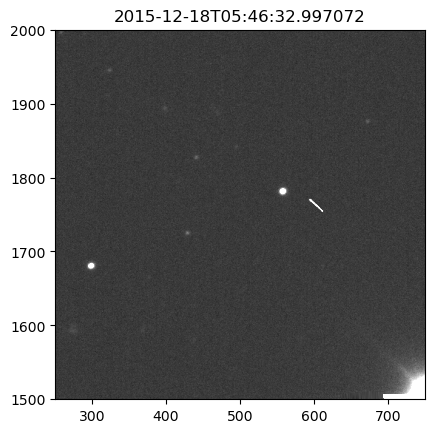

86dc03d642083c4411ef7acb103b7ed6_c4d_151218_060346_ooi_g_v1.fits.fz 1


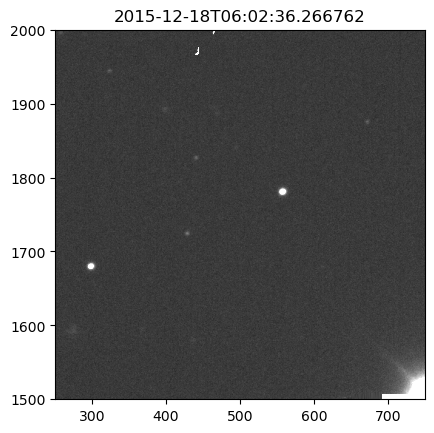

In [15]:
for i, imname in enumerate(imnames_timeordered[0:40:20]):

    image_data = fits.getdata(ROOTDIR + '/dwfflare/' + imname, ext=16)
    image_header = fits.getheader(ROOTDIR + '/dwfflare/' + imname, ext=0)

    plt.imshow(np.rot90(image_data), cmap='gray', clim=(0,100))
    plt.title(image_header['DATE-OBS'])
    print(imname, i)
    plt.gca().invert_yaxis()
    #plt.gca().invert_xaxis()
    plt.xlim(250,750)
    plt.ylim(1500,2000)
    plt.show()

# SAVE FITS FILES FOR EXT 16 ONLY

In [16]:
#ONLY NEED TO DO IT ONCE
for name in imnames_timeordered:
    defs.makefitsfromext(ROOTDIR + '/dwfflare/' + name, ext=16, outdir=ROOTDIR + '/dwfflare/dwfflareS18/'+ name[:-8] + '_S18.fits.fz')

In [17]:
times = []

for imname in imnames_timeordered:
    imname = imname[:-8] + '_S18' + imname[-8:]
    file = 'dwfflare/dwfflareS18/' + imname 
    header = fits.getheader('dwfflare/dwfflareS18/' + imname)
    time = Time(header['DATE-OBS'])
    times.append(time)

len(times)

74

Img 0


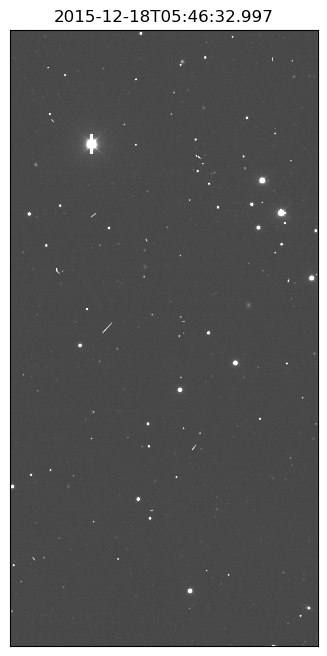

Img 1


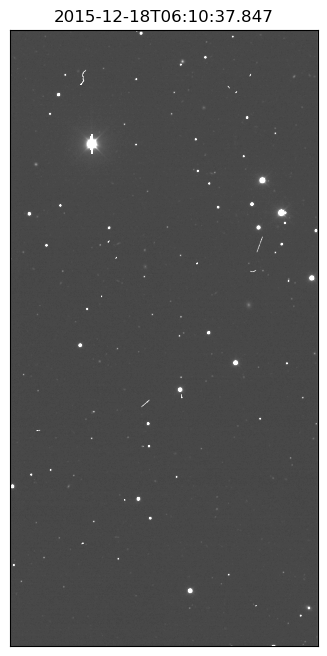

In [18]:
#Look at first 10 imgs
for i, imname in enumerate(imnames_timeordered[0:60:30]):
    imname = imname[:-8] + '_S18' + imname[-8:]
    file = 'dwfflare/dwfflareS18/' + imname 
    data = fits.getdata('dwfflare/dwfflareS18/' + imname)
    header = fits.getheader('dwfflare/dwfflareS18/' + imname)
    wcs = WCS(header)
    time = Time(header['DATE-OBS'])

    print('Img {}'.format(i))
    plt.figure(figsize=(16,8))
    plt.imshow(data, cmap='Greys_r', clim=(0,100))
    plt.title('{}'.format(time))
    plt.xticks([])
    plt.yticks([])
    plt.show()